**MIMO PROTOYPE**:

Here we try our hand at making MIMO work, and testing its validity with a synthetic toy dataset

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# import lightning as L

from torch.utils.data import DataLoader, Dataset

***Making the dataset***

We start by making a toy dataset, which will enable us to better understand the network. Since we have full control over the data, we can see how changes impact MIMO.

The most basic problems we can solve with a MIMO-configured neural network is regression. Classification would also be a somewhat simple problem to solve. 

We first generate training data from the function
$$y = x + 0.3 \sin{(2\pi (x+ \epsilon)) + 0.3 \sin{(4\pi (x+\epsilon))}} $$
as described by Blundell et al.

We use $N_{train}=500$ training points and $N_{test}$ testing points. 

In [4]:
# Regression data function
f = lambda x, epsilon: x + 0.3 * np.sin(2*np.pi * (x+epsilon)) + 0.3 * np.sin(4 * np.pi * (x+epsilon)) + epsilon

# Generate train data
N_train = 500
x = np.linspace(-0.2, 1.0, N_train)

y = []
for i in range(N_train):
    epsilon = np.random.normal(0, 0.02)
    y.append(f(x[i], epsilon))

# Generate test data
N_test = 200
x_test = np.hstack((np.linspace(-0.5, -0.2, 100), np.linspace(1.0, 1.5, 100)))
y_test = []
for i in range(N_test):
    epsilon = np.random.normal(0, 0.02)
    y_test.append(f(x_test[i], epsilon))

x2 = np.linspace(-0.5, 1.5, N_train)
line = f(x2, 0)

We make a custom toy dataset class for the MIMO model. During training, the $M$ subnetworks in the model each get a different batch of training samples. We can do this by multiplying the batch size with a factor $M$ such that the effective batch size is:
$$
batch\_size^* = \frac{batch\_size}{M}
$$
This is implemented using a custom collate function.

During inference, the $M$ subnetworks in the model each get the same input. We implement this by multiplying the input $M$ times using another collate function.

In [5]:
class ToyDataset(Dataset):
    """Custom toy dataset"""

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):

        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)
    
def train_collate_fn(batch, M):
    """Collate function for training"""
    
    x, y = zip(*batch)
    
    x_chunks = torch.stack(torch.chunk(torch.tensor(x), M, dim=0), dim=1)
    y_chunks = torch.stack(torch.chunk(torch.tensor(y), M, dim=0), dim=1)

    return x_chunks, y_chunks

def test_collate_fn(batch, M):
    """Collate function for testing"""
    
    x, y = zip(*batch)
    x = torch.tensor(x)[:,None].repeat(1,M)
    y = torch.tensor(y)[:,None].repeat(1,M)

    return x, y

In [6]:


M = 3
traindata = ToyDataset(x, y)
trainloader = DataLoader(traindata, batch_size=60*M, shuffle=True, collate_fn=lambda x: train_collate_fn(x, M), drop_last=True)

testdata = ToyDataset(x_test, y_test)
testloader = DataLoader(testdata, batch_size=60, shuffle=False, collate_fn=lambda x: test_collate_fn(x, M), drop_last=False)

t_loader = DataLoader(traindata, batch_size=60, shuffle=False, collate_fn=lambda x: test_collate_fn(x, M), drop_last=False)

# Testing
Testing shape of output from train and test loaders

The ``trainloader`` should output a batch where columns are different.

In [7]:
for x_train,y_train in trainloader:
    print(x_train.shape)
    print(y_train.shape)
    break

print(x_train)

torch.Size([60, 3])
torch.Size([60, 3])
tensor([[ 0.6176,  0.1872,  0.3988],
        [ 0.4156,  0.2136,  0.8701],
        [ 0.8172,  0.5359,  0.7307],
        [ 0.7090,  0.1776,  0.9928],
        [ 0.2088,  0.0068,  0.5936],
        [ 0.6248,  0.8749, -0.0918],
        [ 0.8942,  0.5070,  0.7162],
        [ 0.2449, -0.0413,  0.1295],
        [ 0.5094,  0.8148, -0.0389],
        [ 0.8533, -0.1591,  0.1463],
        [ 0.3218,  0.2882,  0.6297],
        [ 0.4132,  0.6321,  0.1222],
        [ 0.5166, -0.1014,  0.0573],
        [ 0.8725,  0.3435,  0.7643],
        [ 0.8918,  0.4733, -0.1808],
        [ 0.7884,  0.3363,  0.9904],
        [ 0.0092,  0.4661,  0.0020],
        [ 0.8341, -0.0076,  0.8990],
        [ 0.0886,  0.4445,  0.7234],
        [ 0.6008,  0.7427,  0.0453],
        [ 0.7355, -0.1062,  0.5118],
        [ 0.9375,  0.7331,  0.6609],
        [ 0.9206,  0.1968,  0.4012],
        [ 0.3098,  0.7379,  0.4926],
        [ 0.6874,  0.7715,  0.1271],
        [ 0.6200,  0.5238,  0.0501]

The ``testloader`` should output a batch where columns are the same.

In [8]:
for test_x, test_y in testloader:
    print(test_x.shape)
    print(test_y.shape)
    break

print(test_x)

torch.Size([60, 3])
torch.Size([60, 3])
tensor([[-0.5000, -0.5000, -0.5000],
        [-0.4970, -0.4970, -0.4970],
        [-0.4939, -0.4939, -0.4939],
        [-0.4909, -0.4909, -0.4909],
        [-0.4879, -0.4879, -0.4879],
        [-0.4848, -0.4848, -0.4848],
        [-0.4818, -0.4818, -0.4818],
        [-0.4788, -0.4788, -0.4788],
        [-0.4758, -0.4758, -0.4758],
        [-0.4727, -0.4727, -0.4727],
        [-0.4697, -0.4697, -0.4697],
        [-0.4667, -0.4667, -0.4667],
        [-0.4636, -0.4636, -0.4636],
        [-0.4606, -0.4606, -0.4606],
        [-0.4576, -0.4576, -0.4576],
        [-0.4545, -0.4545, -0.4545],
        [-0.4515, -0.4515, -0.4515],
        [-0.4485, -0.4485, -0.4485],
        [-0.4455, -0.4455, -0.4455],
        [-0.4424, -0.4424, -0.4424],
        [-0.4394, -0.4394, -0.4394],
        [-0.4364, -0.4364, -0.4364],
        [-0.4333, -0.4333, -0.4333],
        [-0.4303, -0.4303, -0.4303],
        [-0.4273, -0.4273, -0.4273],
        [-0.4242, -0.4242, -0.4242]

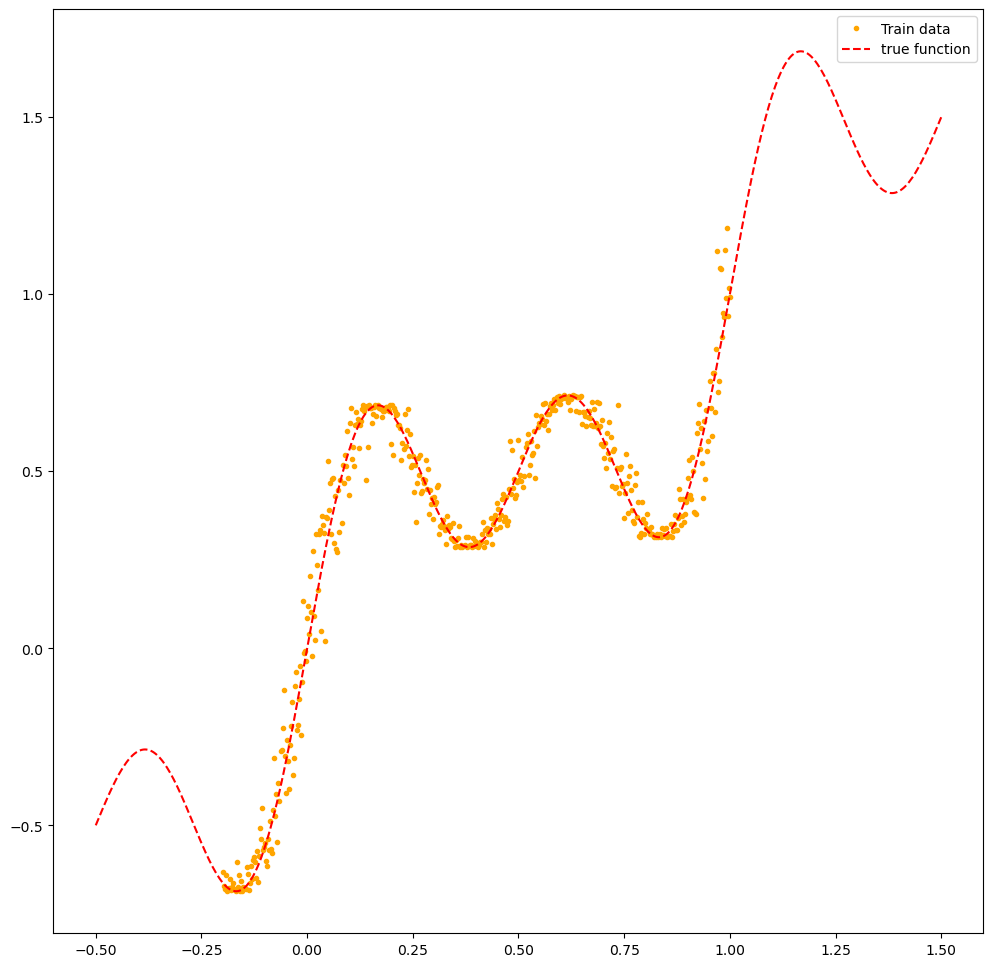

In [9]:
# plot data
fig, ax = plt.subplots(1,1, figsize=(12,12))

ax.plot(x, y, '.', label='Train data', color='orange')
# ax.plot(x_test, y_test, '.', label='Test data', color='blue')
ax.plot(x2, line, '--', label='true function', color='red')
ax.legend()
plt.show()

***Building the model***

The model is a MIMO configured neural network. To keep it simple for now we choose to have $M=2$, so we use 2 subnetworks.
The neural network will consist of two feed-forward aka linear layers with 32 and 128 hidden units in each. For activation function we will use ReLU as it is the norm within the field.

We choose the number of hidden units we did, so that our architecture would be the same as the one given in the MIMO paper when they fit a MIMO model to this synthetic data.

We make sure that we can get both the averaged output (ensemble output) and individual ensemble member output. This will help us illustrate the diversity of the ensemble members.

In [11]:
# from lightning.pytorch.utilities.types import OptimizerLRScheduler
hidden_units = 32
hidden_units2 = 128

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            nn.Linear(M, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units,hidden_units2),
            nn.ReLU(),
            nn.Linear(hidden_units2, M)
        )

    def forward(self, x):
        individual_outputs = self.model(x)
        output = torch.mean(individual_outputs, dim=1)
        return output, individual_outputs

model = NeuralNetwork()


# class LightningNetwork(L.LightningModule):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model
        
#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         x,y = x.float(), y.float()
#         output, individual_outputs = self.model(x)
#         loss = nn.functional.mse_loss(individual_outputs, y)
#         print(loss)
#         self.log("train_loss", loss)
#         return loss
    
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
#         return optimizer


# model = LightningNetwork(model)


In [428]:
#Train model
trainer = L.Trainer(limit_train_batches = 100, max_epochs= 50)
trainer.fit(model, train_dataloaders=trainloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params
----------------------------------------
0 | model | NeuralNetwork | 4.7 K 
----------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\malth\anaconda3\envs\mastersthesis\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 72.94it/s, v_num=34]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 42.93it/s, v_num=34]


In [33]:
model = NeuralNetwork()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

epochs = 15000

for e in range(epochs):

    for x_, y_ in trainloader:

        x_,y_ = x_.float(), y_.float()

        optimizer.zero_grad()

        output, individual_outputs = model(x_)
        loss = nn.functional.mse_loss(individual_outputs, y_)

        loss.backward()
        optimizer.step()

    

# Inference
We test the model on the test set and try to predict the function. First we compute the mean predictions.

In [37]:
predictions1 = []
test_ys1 = []

for test_x, test_y in t_loader:
    output, _ = model(test_x.float())
    
    predictions1.extend(list(output.detach().numpy()))
    test_ys1.extend(list(test_y.detach().numpy()[:,0]))

print(predictions1)
print(test_ys1)

[-0.7050696, -0.7031924, -0.7013151, -0.69943804, -0.6975606, -0.69568324, -0.69380623, -0.69192904, -0.69005173, -0.68817466, -0.68629724, -0.68442005, -0.68254286, -0.68066555, -0.67878836, -0.6769111, -0.67503387, -0.67315674, -0.67127943, -0.66940206, -0.667525, -0.66564775, -0.66377044, -0.6618933, -0.6600159, -0.65813875, -0.65605575, -0.6538549, -0.6516542, -0.6494534, -0.6472525, -0.6448303, -0.63971287, -0.6340645, -0.62831515, -0.62236786, -0.6159527, -0.6073721, -0.598731, -0.5900204, -0.58130985, -0.5725993, -0.56388855, -0.55521816, -0.54656476, -0.537911, -0.5292576, -0.5193343, -0.5067876, -0.49388146, -0.47997975, -0.4660072, -0.4520346, -0.43806195, -0.42408934, -0.4101167, -0.3961439, -0.3819423, -0.3675506, -0.35315904, -0.33877325, -0.32440126, -0.3100294, -0.29565766, -0.28128585, -0.26684368, -0.25249696, -0.23824833, -0.22399984, -0.20975126, -0.19550282, -0.18124898, -0.16631353, -0.15101084, -0.1356711, -0.120367885, -0.10506479, -0.08925489, -0.07263688, -0.05

In [38]:
predictions2 = []
test_ys2 = []

for test_x, test_y in testloader:
    output, _ = model(test_x.float())
    
    predictions2.extend(list(output.detach().numpy()))
    test_ys2.extend(list(test_y.detach().numpy()[:,0]))

print(predictions2)
print(test_ys2)

[-0.907485, -0.9057939, -0.904103, -0.90241176, -0.90072036, -0.8990297, -0.8973382, -0.89564687, -0.893956, -0.8922648, -0.8905735, -0.8888826, -0.8871915, -0.88550043, -0.8836921, -0.8818837, -0.88007516, -0.87826675, -0.8764584, -0.87465, -0.87284184, -0.8710334, -0.8692248, -0.8674168, -0.86560845, -0.8638, -0.8619912, -0.8601832, -0.85837466, -0.8565667, -0.8547581, -0.85294986, -0.8511413, -0.84933287, -0.84752446, -0.8457163, -0.843908, -0.84209967, -0.84029126, -0.83848286, -0.83667463, -0.8348661, -0.8330577, -0.83124954, -0.82944125, -0.82763284, -0.8258243, -0.8240158, -0.8222075, -0.8203992, -0.8185908, -0.8167825, -0.81497407, -0.81316596, -0.8113575, -0.8091518, -0.80678606, -0.80442095, -0.80205536, -0.79969, -0.7973244, -0.79495883, -0.7925932, -0.79022783, -0.7878621, -0.7854968, -0.7831314, -0.78076595, -0.7784001, -0.77603465, -0.773669, -0.77130383, -0.76893824, -0.7665729, -0.76420754, -0.7618418, -0.759476, -0.75711066, -0.7547452, -0.75237983, -0.7500141, -0.7476

Then we compute predictions for individual members.

In [39]:
pred_individual = []

for test_x, test_y in t_loader:
    _ , individual_outputs = model(test_x.float())
    
    pred_individual.extend(list(individual_outputs.detach().numpy()))

pred_individual = np.array(pred_individual)

In [40]:
pred_individual2 = []

for test_x, test_y in testloader:
    _ , individual_outputs = model(test_x.float())
    
    pred_individual2.extend(list(individual_outputs.detach().numpy()))

pred_individual2 = np.array(pred_individual2)

**Analysis**

We need to analyse the trained network to see if the MIMO network works as desired. We try to replicate some of the plots in the MIMO paper to make sure that it works properly.

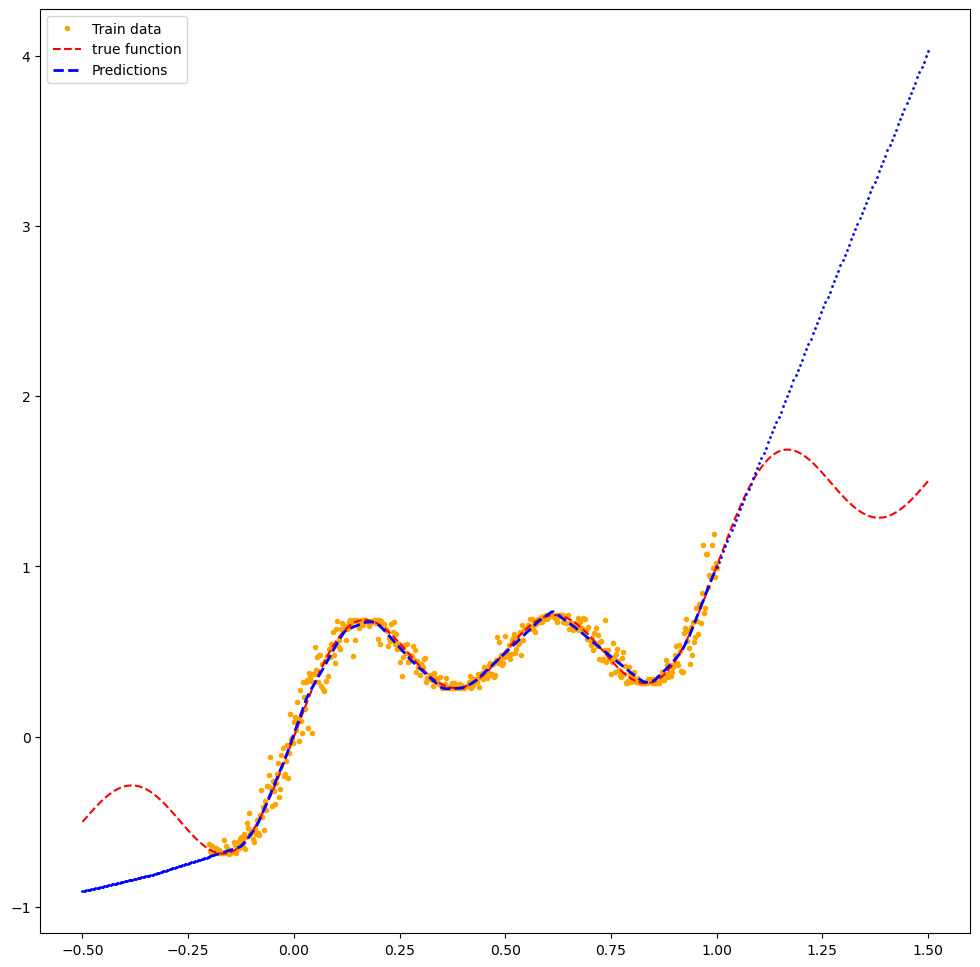

In [84]:
# plot data
fig, ax = plt.subplots(1,1, figsize=(12,12))

ax.plot(x, y, '.', label='Train data', color='orange')
# ax.plot(x_test, test_ys2, '.', label='Test data', color='green')
ax.plot(x2, line, '--', label='true function', color='red')
ax.plot(x, predictions1, '--', label='Predictions', color='blue', linewidth=2)
ax.plot(x_test, predictions2, '.', color='blue', markersize=2)

# # member predictions
# ax.plot(x, pred_individual[:,0], '-', label='Member0', color='maroon', linewidth=1)
# ax.plot(x, pred_individual[:,1], '-', label='Member1', color='magenta', linewidth=1)
# ax.plot(x, pred_individual[:,2], '-', label='Member2', color='cyan', linewidth=1)
# ax.plot(x, pred_individual2[:,0], '-', color='maroon', linewidth=1)
# ax.plot(x2, pred_individual2[:,1], '-',  color='magenta', linewidth=1)
# ax.plot(x2, pred_individual2[:,2], '-',  color='cyan', linewidth=1)

ax.legend()
plt.show()